In [1]:
from tensorflow.keras.applications import (
    ResNet50, ResNet101,
    EfficientNetB0,
    DenseNet121,
    MobileNetV2,
)
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet101_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess

import tensorflow as tf
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
from pathlib import Path

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(
    "mrmaazoo/breast-ultrasound-classification",
)

print("Path to dataset files:", path)



d:\User\毒蛇\Documents\GitHub\The_Practice_of_Deep_Learning_Biomedical_Image_analysis_Final_Exam\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\ihvgj\.cache\kagglehub\datasets\mrmaazoo\breast-ultrasound-classification\versions\1


In [3]:
def get_model_and_preprocess(name: str):
    name = name.lower()
    if name == "resnet50":
        return ResNet50, resnet50_preprocess
    elif name == "resnet":
        return ResNet101, resnet101_preprocess
    elif name == "efficientnetb0":
        return EfficientNetB0, efficientnet_preprocess
    elif name == "densenet121":
        return DenseNet121, densenet_preprocess
    elif name == "mobilenetv2":
        return MobileNetV2, mobilenetv2_preprocess
    else:
        raise ValueError(f"Unsupported model name: {name}")

# 範例：指定要用的模型
MODEL_NAME = "efficientnetb0"
ModelClass, preprocess_input = get_model_and_preprocess(MODEL_NAME)


In [4]:
import matplotlib.pyplot as plt

# ========== 7. 視覺化 ==========
def plot_history(history, title_suffix=""):
    plt.figure()
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss {title_suffix}")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy {title_suffix}")
    plt.legend()
    plt.show()

In [5]:


# ========== 0. 基本設定 ==========
DATA_DIR   = Path(path) / "BUSI_Corrected"   # <-- 把 path 換成你的資料根目錄
IMG_SIZE   = (256, 256)                      # ★ 改成 256 × 256
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE
EPOCHS_TOP = 200   # 先訓練頂層

# ========== 1. 蒐集檔名 (排除 _mask.png) & 分層切分 ==========
class_names = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])

filepaths, labels = [], []
for cls_idx, cls_name in enumerate(class_names):
    for img_path in (DATA_DIR / cls_name).glob("*.png"):
        if "_mask" in img_path.stem:          # ★ 排除 segmentation mask
            continue
        filepaths.append(str(img_path))
        labels.append(cls_idx)

filepaths, labels = np.array(filepaths), np.array(labels)

train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_paths, val_paths = filepaths[train_idx], filepaths[val_idx]
train_labels, val_labels = labels[train_idx],  labels[val_idx]

# ========== 2. tf.data pipeline ==========
def load_and_prep(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img)          # BUSI 為灰階，但轉 3ch 便於載權重
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.uint8)
    img = tf.image.equalize(img)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)                         # ★ 用官方前處理
    return img, label

augmenter = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])

def make_dataset(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(1000)
    ds = ds.map(load_and_prep, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (augmenter(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_dataset(train_paths, train_labels, training=True)
val_ds   = make_dataset(val_paths, val_labels, training=False)

# ========== 3. 類別權重 ==========
cw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(cw))

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.3142 - loss: 1.1521 - val_accuracy: 0.3200 - val_loss: 1.1556 - learning_rate: 1.0000e-05
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.3810 - loss: 1.0682 - val_accuracy: 0.3067 - val_loss: 1.1530 - learning_rate: 1.0000e-05
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.3959 - loss: 1.1173 - val_accuracy: 0.3333 - val_loss: 1.1316 - learning_rate: 1.0000e-05
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.3956 - loss: 1.0607 - val_accuracy: 0.3600 - val_loss: 1.1047 - learning_rate: 1.0000e-05
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.4252 - loss: 1.0283 - val_accuracy: 0.3733 - val_loss: 1.0836 - learning_rate: 1.0000e-05
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.4740 - loss: 1.0364 - val_accuracy: 0.3933 - val_loss: 1.0689 - learning_rate: 1.0000e-05
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.4941 

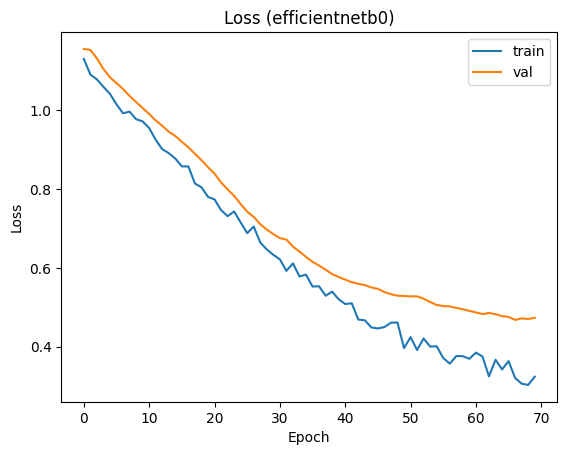

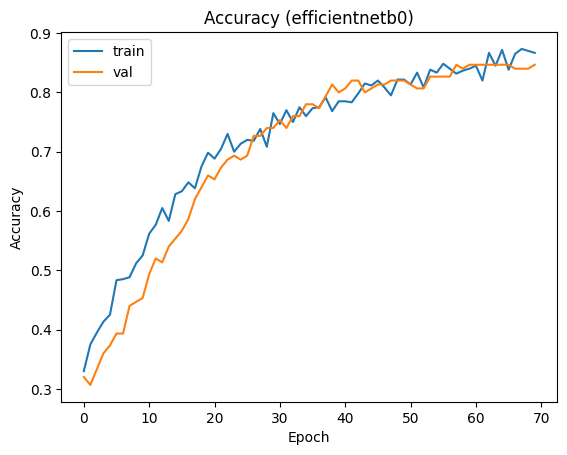

In [6]:
# ========== 4. 建立模型（動態模型） ==========

import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# 假設前面已經執行：
# ModelClass, preprocess_input = get_model_and_preprocess(MODEL_NAME)

# 1) 用 ModelClass 來建 base model
base = ModelClass(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights="imagenet"
)
base.trainable = True  # 如果要凍結就設 False，這裡先示範開訓練頂層所以留 True

# 2) 定義整體模型架構
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ========== 5. 訓練頂層 ==========

history_top = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_TOP,
    class_weight=class_weight_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=2
        )
    ]
)

plot_history(history_top, f"({MODEL_NAME})")
best_acc = max(history_top.history['val_accuracy'])
print(f'Best validation accuracy: {best_acc:.4f}')


Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4869 - loss: 1.1776 - val_accuracy: 0.6333 - val_loss: 0.7912 - learning_rate: 0.0010
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6421 - loss: 0.7524 - val_accuracy: 0.7000 - val_loss: 0.7082 - learning_rate: 0.0010
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7501 - loss: 0.5832 - val_accuracy: 0.7600 - val_loss: 0.6067 - learning_rate: 0.0010
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7671 - loss: 0.5492 - val_accuracy: 0.7667 - val_loss: 0.5988 - learning_rate: 0.0010
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7922 - loss: 0.5080 - val_accuracy: 0.7733 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8367 - loss: 0.4789 - val_accuracy: 0.7733 - val_loss: 0.5384 - learning_rate: 0.0010
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7935 - loss: 0.4663 - val_acc

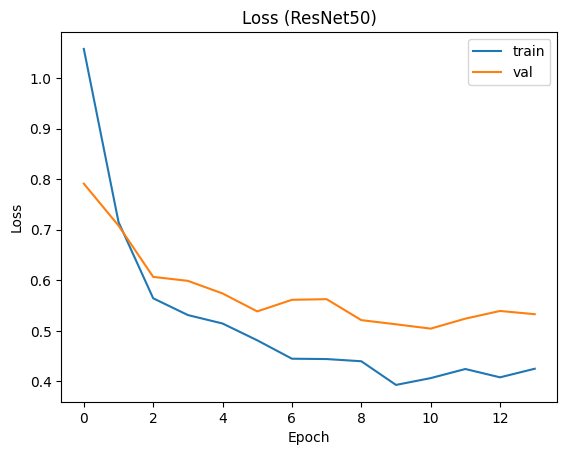

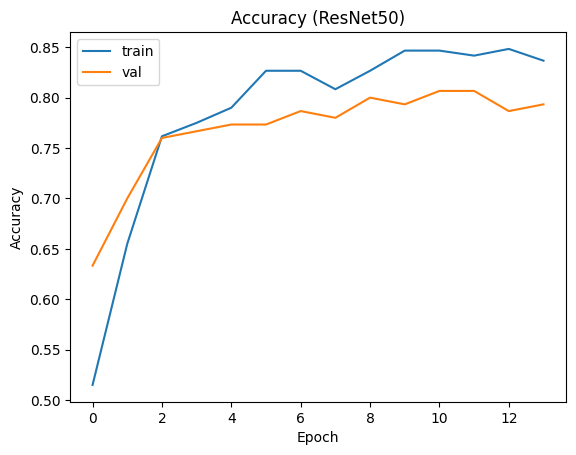

In [7]:
# --- ResNet50 模型訓練 ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

# 使用 ResNet50，不包含頂層分類器
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=IMG_SIZE + (3,)))
base_model.trainable = False  # 先凍結特徵提取層

# 加上分類頭
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(class_names), activation="softmax")(x)
model_resnet = Model(inputs=base_model.input, outputs=output)

# 編譯模型
model_resnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 資料前處理（根據 ResNet 要求）
train_ds_resnet = train_ds.map(lambda x, y: (resnet_preprocess(x), y))
val_ds_resnet = val_ds.map(lambda x, y: (resnet_preprocess(x), y))

# 訓練模型
history_resnet = model_resnet.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=EPOCHS_TOP,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=2
        )
    ]
)

plot_history(history_resnet, title_suffix="(ResNet50)")
best_acc = max(history_resnet.history['val_accuracy'])
print(f'Best validation accuracy: {best_acc:.4f}')


Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4980 - loss: 1.0656 - val_accuracy: 0.5733 - val_loss: 0.8831 - learning_rate: 0.0010
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5554 - loss: 0.9369 - val_accuracy: 0.6867 - val_loss: 0.8043 - learning_rate: 0.0010
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6233 - loss: 0.8274 - val_accuracy: 0.7200 - val_loss: 0.7521 - learning_rate: 0.0010
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6881 - loss: 0.7145 - val_accuracy: 0.6933 - val_loss: 0.7124 - learning_rate: 0.0010
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7366 - loss: 0.6532 - val_accuracy: 0.7067 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6779 - loss: 0.6968 - val_accuracy: 0.7000 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7256 - loss: 0.6542 - val_acc

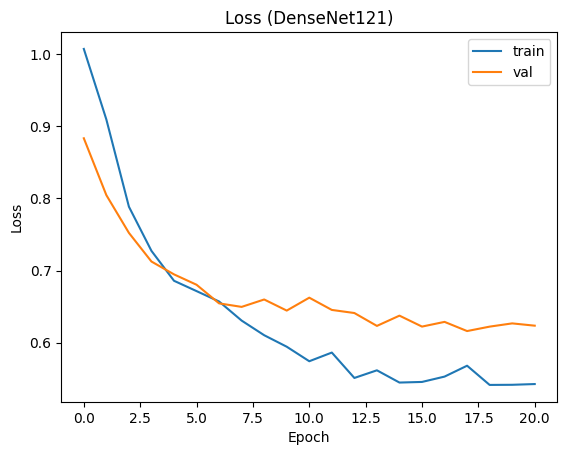

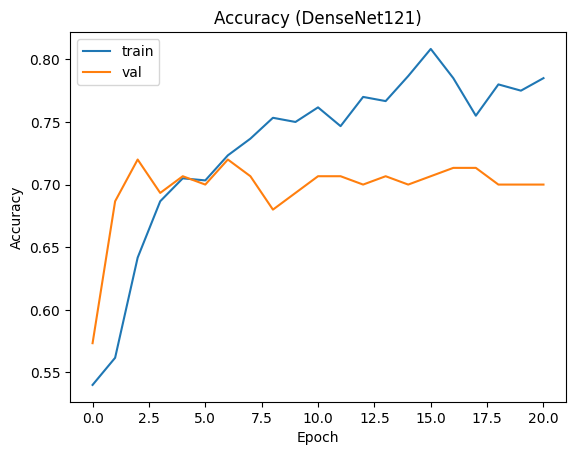

In [8]:
# --- DenseNet121 模型訓練 ---
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

# 使用 DenseNet121，不包含頂層分類器
base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=IMG_SIZE + (3,)))
base_model.trainable = False

# 加上分類頭
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(class_names), activation="softmax")(x)
model_densenet = Model(inputs=base_model.input, outputs=output)

# 編譯模型
model_densenet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 資料前處理（根據 DenseNet 要求）
train_ds_dense = train_ds.map(lambda x, y: (densenet_preprocess(x), y))
val_ds_dense = val_ds.map(lambda x, y: (densenet_preprocess(x), y))

# 訓練模型
history_densenet = model_densenet.fit(
    train_ds_dense,
    validation_data=val_ds_dense,
    epochs=EPOCHS_TOP,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=2
        )
    ]
)

plot_history(history_densenet, title_suffix="(DenseNet121)")best_acc = max(history_densenet.history['val_accuracy'])
print(f'Best validation accuracy: {best_acc:.4f}')
